<a href="https://colab.research.google.com/github/LevFRFR/titanic_classification/blob/main/titanic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan:
- Look at big picture
- Get the data
- Explore and visualize the data
- Prepare the data for machine learning algorithms
- Select a model and train it
- Fine-tune the model
- Present solution
- Launch

## Look at the big picture

**Problem**: build a classifier to predict who survives the infamous titanic catastrophe and who does not.



## Get the data

In [ ]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get__Data(set = 'train'):
  f = f'/content/drive/MyDrive/Colab Notebooks/ml project #1 2023-01-25/data/{str(set)}.csv'
  return pd.read_csv(f)

data = get__Data()

### Set random seed

In [ ]:
# set random seed
np.random.seed(42)

### Create a Test Set

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
titanic = train_set.copy()
# titanic = data

## Explore and visualize the data

In [ ]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic.info()

# features `Age`, `Embarked` & `Cabin` would require missing value treatment since they contain nulls.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
titanic.select_dtypes([np.number]).columns

# the following columns are numeric, will need to check the whether the distribution is bell-shaped
# to ensure minimum bias during training

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [ ]:
titanic.select_dtypes(object).columns

# meanwhile, these are all the string column
# consider cutting some out and cleaning data prepping others

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

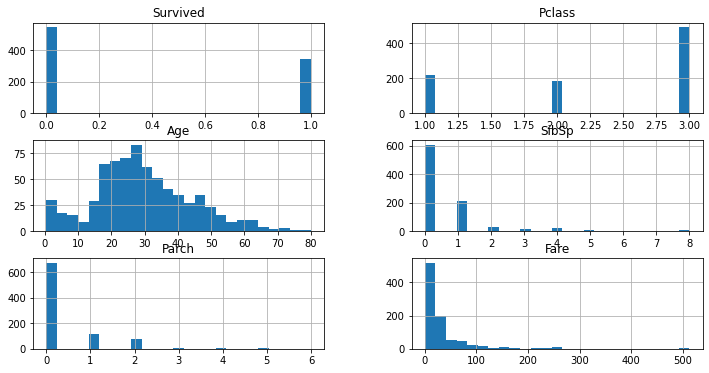

In [ ]:
titanic.drop(columns='PassengerId').hist(bins=25, figsize=(12,6))
plt.show()

# seemingly most of the features (excluding the label of `survived`) have a tendency to skew rightward
# (have more records spanning further right of the median value)

# additionally, Pclass sounds like it should be a categorical feature, not numerical

### Checking for correlation

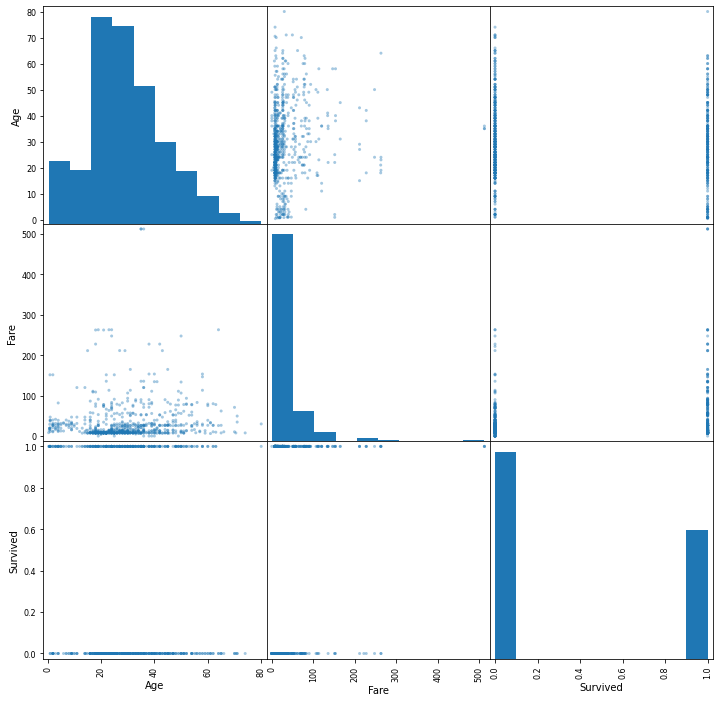

In [ ]:
from pandas.plotting import scatter_matrix

# attributes = ['Age', 'SibSp', 'Parch', 'Fare']
attributes = ['Age', 'Fare', 'Survived']

scatter_matrix(titanic[attributes], figsize=(12,12), alpha=0.4)
plt.show()

# at the second glance, every feature except age and fare look like they should be treated as categorical

In [ ]:
corr_matrix = titanic.drop(columns='PassengerId').corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [ ]:
titanic.value_counts('Parch')

Parch
0    678
1    118
2     80
3      5
5      5
4      4
6      1
dtype: int64

In [ ]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Plan after day 1:
And quick notes about assumptions...
- Keep `Fare` as is, produce a log of it to create distribution closer to a bell-shape.
- turn `Parch` into categorical variable (lone survivor, couple, group).
- potentially same with `SibSp`.
- Get RBF Similarity function working for `Age`'s mode.
- Turn `Pclass` into low- & high- classes (the lower the class — the higher likelihood of survival).

## Clean Data

In [ ]:
titanic = train_set.drop('Survived', axis=1)
titanic_labels = train_set['Survived'].copy()

### Handling Missing Values

In [ ]:
# imputing age feature

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
titanic_age = titanic[['Age']]
imputer.fit(titanic_age)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_
# median age 28

array([28.])

### Handling categorical features

In [ ]:
titanic_cat = titanic[['Sex','Pclass']]
titanic_cat.head()

,Sex,Pclass
331,male,1
733,male,2
382,male,3
704,male,3
813,female,3


In [ ]:
# use one hot encoder on categorical variables

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
titanic_cat_1hot = cat_encoder.fit_transform(titanic_cat)
titanic_cat_1hot

<712x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1424 stored elements in Compressed Sparse Row format>

### Feature Scaling and Transforming

In [ ]:
titanic['Fare'].sort_values(ascending=True)

# there are some zeroes in the column, so we might need to get rid of them before logging it

# create a new feature: paid or free ticket?

271      0.0000
674      0.0000
302      0.0000
466      0.0000
179      0.0000
         ...   
341    263.0000
438    263.0000
679    512.3292
737    512.3292
258    512.3292
Name: Fare, Length: 712, dtype: float64

In [ ]:
idx_nonzero_fare = titanic['Fare'] != 0

fare_without_unpaid = titanic['Fare'][idx_nonzero_fare]
fare_without_unpaid

331     28.5000
733     13.0000
382      7.9250
704      7.8542
813     31.2750
         ...   
106      7.6500
270     31.0000
860     14.1083
435    120.0000
102     77.2875
Name: Fare, Length: 699, dtype: float64

In [ ]:
# changing zeroes to negative infinity so log is computable
fare_num_log = np.log( np.where( titanic['Fare'] == 0, np.NINF, titanic['Fare'] ) )

<ipython-input-22-d077a8599e32>:2: RuntimeWarning: invalid value encountered in log
  fare_num_log = np.log( np.where( titanic['Fare'] == 0, np.NINF, titanic['Fare'] ) )


In [ ]:
np.log(np.NINF)

<ipython-input-23-71539abeacaf>:1: RuntimeWarning: invalid value encountered in log
  np.log(np.NINF)


nan

In [ ]:
pd.Series(fare_num_log)

0      3.349904
1      2.564949
2      2.070022
3      2.061048
4      3.442819
         ...   
707    2.034706
708    3.433987
709    2.646763
710    4.787492
711    4.347532
Length: 712, dtype: float64

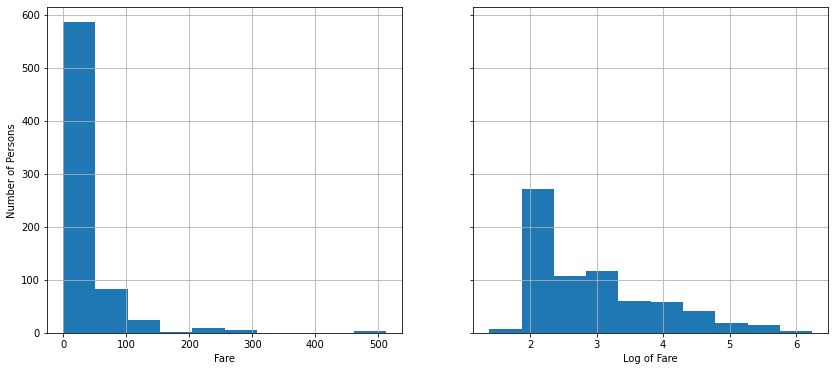

In [ ]:
# extra code – this cell generates Figure 2–17
def plot2graphs(data1, data2):
  fig, axs = plt.subplots(1, 2, figsize=(14,6), sharey=True)
  data1.hist(ax=axs[0], bins=10)
  data2.hist(ax=axs[1], bins=10)
  # pd.Series(fare_num_log).hist(ax=axs[1], bins=10)
  axs[0].set_xlabel(data1.name)
  axs[1].set_xlabel(f"Log of {data1.name}")
  axs[0].set_ylabel("Number of Persons")
  # save_fig("long_tail_plot")
  plt.show()


plot2graphs(titanic['Fare'], pd.Series(fare_num_log))
# this data still looks a little too skewed
# let's try power transformation

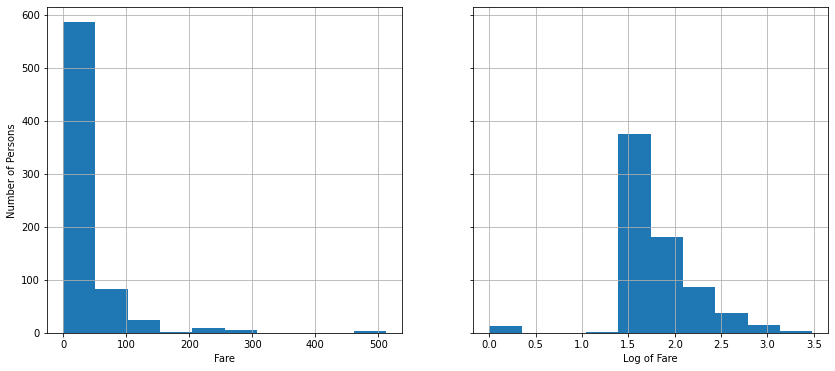

In [ ]:
plot2graphs(titanic['Fare'],titanic['Fare']**(1/5))

# ooh, looks better but still weird

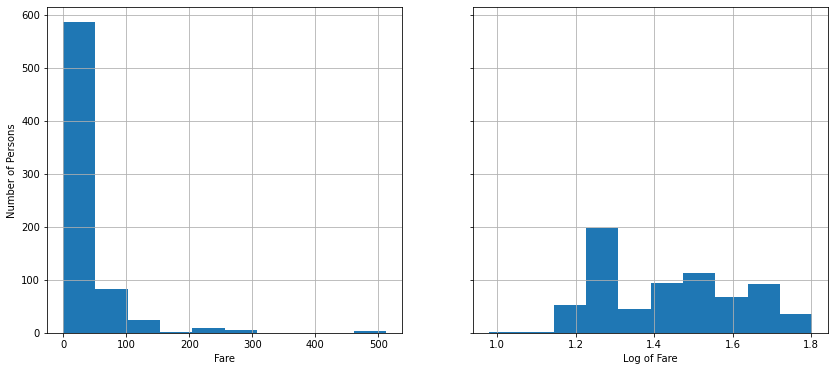

In [ ]:
from scipy.stats import boxcox

bc_fare = pd.Series( boxcox(fare_without_unpaid)[0] )

plot2graphs(titanic['Fare'], bc_fare )

# good enough, although this is starting to look multimodal...

In [ ]:
X = imputer.transform(titanic_age)

pd.DataFrame(X, columns=imputer.feature_names_in_)

,Age
0,45.5
1,23.0
2,32.0
3,26.0
4,6.0
...,...
707,21.0
708,28.0
709,41.0
710,14.0


In [ ]:
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer(method='yeo-johnson')
titanic_fare = power_transformer.fit_transform(titanic[['Fare']])

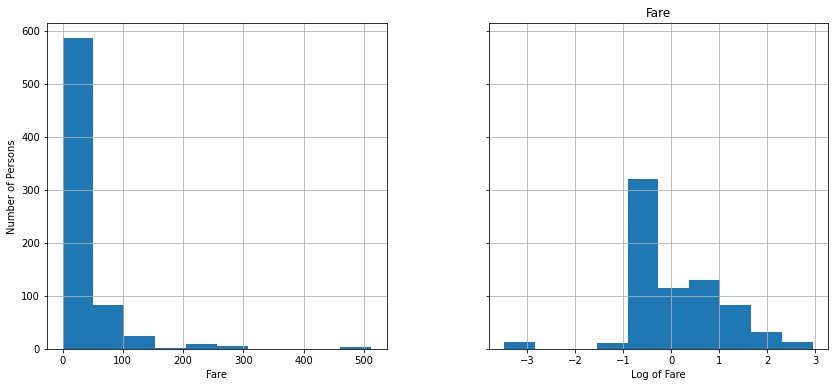

In [ ]:
plot2graphs(titanic['Fare'], pd.DataFrame(titanic_fare, columns = power_transformer.feature_names_in_))


### Feature Engineering

In [ ]:
titanic['FareType'] = np.where(
    titanic['Fare'] == 0,
    'Free',
    'Paid'
)
titanic['FareType'].value_counts()

# hm, it's just 15 that are free, doesn't seem like it would have a big impact

Paid    699
Free     13
Name: FareType, dtype: int64

In [ ]:
# instead let's go back to my previous plan...

# let's create a feature that checks for whether the person was alone, with a partner, or in a group

In [ ]:
titanic['GroupCount'] = np.select(
    condlist=[
        titanic['Parch'] + titanic['SibSp'] == 0,
        titanic['Parch'] + titanic['SibSp'] == 1,
        titanic['Parch'] + titanic['SibSp'] > 1
    ],
    choicelist=['Alone', 'Couple', 'Group']
)

In [ ]:
titanic['GroupCount'].value_counts()

Alone     429
Group     156
Couple    127
Name: GroupCount, dtype: int64

In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table
ctab = pd.crosstab(titanic_labels, titanic['GroupCount'])

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(ctab)

# Print the results
print("Chi-squared test statistic: ", chi2)
print("p-value: ", p)

Chi-squared test statistic:  24.451006197039813
p-value:  4.903785507705375e-06


In [ ]:
# the p-value is very small suggesting that there's a significant association between survival and the groupsize - it probably has to do with the pull to help others?

### Transformation Pipelines

In [ ]:
titanic['Cabin'].value_counts()
# maybe split at letter and have that as a new feature
# but it might be needed to drop altogether because it is rarely non-null

C23 C25 C27    4
E101           3
B96 B98        3
C22 C26        3
G6             3
              ..
C104           1
D11            1
C86            1
C7             1
C62 C64        1
Name: Cabin, Length: 117, dtype: int64

##### Plan Recap
So far I've got the following preprocessing steps:

- Numerical
  - Fare = median imputing, power tranformation using yeo-johnson
  - Age = median imputing, no transformations

- Categorical (provided) = 1hot encoder
  - Sex
  - Class
  - Parch
  - SibSp

- Discarded
  - PassengerId
  - Name
  - Ticket
  - Embarked

- Categorical (feature engineered)
  - Parch/SibSp -> Alone,Couple,Group
  - Cabin -> A,B,C

In [ ]:
# fixes SimpleImputer not having get_feature_names_out
SimpleImputer.get_feature_names_out = (lambda self, names=None: self.feature_names_in_)

In [ ]:
# let's create a custom transformer to create a new category from given feature
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class NumpySelectTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, n_persons):
    self.n_persons = n_persons
  
  def fit(self, X, y=None): # y is required, even though it is not used. Why?
    self.n_features_in_ = X.shape[1] # how many features in
    if hasattr(X, 'columns'):
      self.feature_names_in = np.array(X.columns)
    return self

  def transform(self, X):
    tempArray = X.iloc[:,0] + X.iloc[:,1]

    conditions = [tempArray == 0, tempArray == 1, tempArray > 1]

    # X['newColumn'] = np.select( conditions, self.n_persons, default=0 ) # this is 1D, not 2D?...

    return np.select( conditions, self.n_persons, default=0 ).reshape(-1, 1) # transposes resulting feature vector

  # def get_feature_names_out(self, input_features=None):
  #   return 'GroupType'

In [ ]:
# define preprocessing pipelines
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    PowerTransformer(method='yeo-johnson')
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

grouping_pipeline = make_pipeline(
    NumpySelectTransformer(n_persons=['Alone', 'Couple', 'Group']),
    OneHotEncoder(handle_unknown='ignore')
)

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer([
    ('num', num_pipeline, ['Fare','Age']),
    # ('grouping', grouping_pipeline, ['SibSp', 'Parch']),
    ('cat', cat_pipeline, ['Sex', 'Pclass', 'Parch', 'SibSp'])
], remainder='drop')

In [ ]:
titanic_prepared = preprocessing.fit_transform( titanic )

In [ ]:
df_titanic_prepared = pd.DataFrame.sparse.from_spmatrix(titanic_prepared, columns=preprocessing.get_feature_names_out(), index=titanic.index)

In [ ]:
df_titanic_prepared

,num__Fare,num__Age,cat__Sex_female,cat__Sex_male,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Parch_0,cat__Parch_1,cat__Parch_2,...,cat__Parch_4,cat__Parch_5,cat__Parch_6,cat__SibSp_0,cat__SibSp_1,cat__SibSp_2,cat__SibSp_3,cat__SibSp_4,cat__SibSp_5,cat__SibSp_8
331,0.479998,1.226568,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
733,-0.283753,-0.436357,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
382,-0.772447,0.252746,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
704,-0.781285,-0.202199,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
813,0.568460,-1.904527,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-0.807217,-0.595373,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
270,0.560073,-0.048707,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
860,-0.203135,0.908453,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
435,1.783869,-1.174832,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# F yeah! This works smoothly.
# Now we can start testing different models.

In [ ]:
df_titanic_prepared.columns

Index(['num__Fare', 'num__Age', 'cat__Sex_female', 'cat__Sex_male',
       'cat__Pclass_1', 'cat__Pclass_2', 'cat__Pclass_3', 'cat__Parch_0',
       'cat__Parch_1', 'cat__Parch_2', 'cat__Parch_3', 'cat__Parch_4',
       'cat__Parch_5', 'cat__Parch_6', 'cat__SibSp_0', 'cat__SibSp_1',
       'cat__SibSp_2', 'cat__SibSp_3', 'cat__SibSp_4', 'cat__SibSp_5',
       'cat__SibSp_8'],
      dtype='object')

## Select and Train the Model

Let's list some of the models that can be helpful:
- Logistic Regression
- Support Vector Machines
- Decision Tree Learning
- KNN
- Stochastic Gradient Descent (SGD)

### SGD

In [ ]:
from sklearn.linear_model import SGDClassifier # importing binary classifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(df_titanic_prepared, titanic_labels)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict(df_titanic_prepared)[:1]

array([0])

In [ ]:
titanic_labels[:1]

331    0
Name: Survived, dtype: int64

In [ ]:
from sklearn.model_selection import cross_val_score

# using cross-validation we split the training set into 3 folds and evaluate it
cross_val_score(sgd_clf, df_titanic_prepared, titanic_labels, cv=3, scoring='accuracy')

# not bad for the first try
# let's check confusion matrices

array([0.77731092, 0.78902954, 0.67088608])

In [ ]:
from sklearn.model_selection import cross_val_predict

titanic_labels_pred = cross_val_predict(sgd_clf, df_titanic_prepared, titanic_labels, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(titanic_labels, titanic_labels_pred)
cm

# 383 individuals were correctly classified as perished (true negatives)
# remaining 61 were wrongly classified as survived (false positives)
# 120 people were wrongly classified as perished (false negatives)
# remaining 148 people were correctly classified as survivors (true positives)

array([[383,  61],
       [120, 148]])

### KNN

In [ ]:
from sklearn.cluster import KMeans

knn_clf = KMeans(n_clusters=2, random_state=42)
knn_clf.fit(df_titanic_prepared, titanic_labels)

KMeans(n_clusters=2, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score

# using cross-validation we split the training set into 3 folds and evaluate it
cross_val_score(knn_clf, df_titanic_prepared, titanic_labels, cv=3, scoring='accuracy')

# not bad for the first try
# let's check confusion matrices

array([0.68907563, 0.61603376, 0.65822785])

In [ ]:
from sklearn.model_selection import cross_val_predict

titanic_labels_pred = cross_val_predict(knn_clf, df_titanic_prepared, titanic_labels, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(titanic_labels, titanic_labels_pred)
cm

# slightly worse than SGD

array([[327, 117],
       [129, 139]])

### Decision Tree Learning

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree_clf.fit(df_titanic_prepared, titanic_labels)

cross_val_score(tree_clf, df_titanic_prepared, titanic_labels, cv=3, scoring='accuracy')

# ooh, looks more consistent than SGD

array([0.76890756, 0.75949367, 0.76793249])

In [ ]:
titanic_labels_pred = cross_val_predict(tree_clf, df_titanic_prepared, titanic_labels, cv=3)

confusion_matrix(titanic_labels, titanic_labels_pred)

# OOH much better, very nice

array([[352,  92],
       [ 75, 193]])

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(titanic_prepared, titanic_labels) # had to use sparse matrix instead of dense one

cross_val_score(svm_clf, titanic_prepared, titanic_labels, cv=3, scoring='accuracy')

# the results are better than tree classifier!

array([0.80672269, 0.83544304, 0.8185654 ])

In [ ]:
titanic_labels_pred = cross_val_predict(svm_clf, titanic_prepared, titanic_labels, cv=3)

confusion_matrix(titanic_labels, titanic_labels_pred)

# ah, well, we get a higher precision, but lower recall

array([[401,  43],
       [ 85, 183]])

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logit_clf = LogisticRegression(random_state=42)
logit_clf.fit(df_titanic_prepared, titanic_labels)

cross_val_score(logit_clf, df_titanic_prepared, titanic_labels, cv=3, scoring='accuracy')

# accuracy on par with SVM

array([0.79411765, 0.80590717, 0.80168776])

In [ ]:
titanic_labels_pred = cross_val_predict(logit_clf, df_titanic_prepared, titanic_labels, cv=3)

confusion_matrix(titanic_labels, titanic_labels_pred)

# we get fewer True Negatives (386), while recall is similar to SVM
# yet we also have lower precision

# I think I will go with SVM

array([[386,  58],
       [ 84, 184]])

# Fine Tune the model

Next, I will tinker in the SVM classifier with the decision function to see if I can find a good trade-off between Precision and Recall.

In [ ]:
from sklearn.model_selection import GridSearchCV

# svm_clf.decision_function

# Submitting the results

## Get test data

In [ ]:
X_test = get__Data('test')

In [ ]:
titanic_test = test_set.drop('Survived', axis=1)
titanic_test_labels = test_set['Survived'].copy()

In [ ]:
from sklearn.pipeline import Pipeline

# svm_clf.decision_function

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('svm', SVC(random_state=42))
])

full_pipeline.fit(titanic, titanic_labels)
# full_pipeline.predict(titanic)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  

In [ ]:
titanic_test_pred = full_pipeline.predict(titanic_test)

In [ ]:
confusion_matrix(titanic_test_labels, titanic_test_pred)

array([[93, 12],
       [22, 52]])

In [ ]:
Y_test = full_pipeline.predict(X_test)

## Write Submission CSV

In [ ]:
submission = X_test.copy()
submission['Survived'] = Y_test
submission = submission[['PassengerId', 'Survived']]
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/ml project #1 2023-01-25/data/submission_1.csv', index=False)